In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import xgboost
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt


# Pre-processing data

In [4]:
# population data
net_mig = pd.read_csv('Cleaned_Data/county_net_out.csv', index_col = 0)
net_mig.columns = ['FIPS', 'year', 'num_ind', 'agi']
#population['FIPS'] =population['FIPS_state'].astype(str).str.zfill(2) + population['FIPS_county'].astype(str).str.zfill(3)
#population['FIPS'] = population['FIPS'].astype(int)

# population numbers
population = pd.read_csv('Cleaned_Data/populations_totals.csv')
population['FIPS'] =population['FIPS_state'].astype(str).str.zfill(2) + population['FIPS_county'].astype(str).str.zfill(3)
population['FIPS'] = population['FIPS'].astype(int)
population.rename(columns={'total':'population_persons'},inplace=True)

# income
income_projection = pd.read_csv('Cleaned_Data/income_projection_estimates.csv')
income_projection['Geo_FIPS'] = income_projection['FIPS_state'].astype(str).str.zfill(2) + income_projection['FIPS_county'].astype(str).str.zfill(3)
income_projection['FIPS'] = income_projection['Geo_FIPS'].astype(int)

# drop weird rows
income_projection = income_projection.loc[income_projection['per_capita_personal_income_dollars'] != '(NA)', :]
income_projection['per_capita_personal_income_dollars'] = income_projection['per_capita_personal_income_dollars'].astype(int)
#income_projection['population_persons'] = income_projection['population_persons'].astype(int)
#income_projection['personal_income_thousands_of_dollars'] = income_projection['personal_income_thousands_of_dollars'].astype(int)

In [5]:
#employment
employment_projection=pd.read_csv('Cleaned_Data/employment_projection_estimates.csv', index_col = 0)
employment_projection['FIPS'] = employment_projection['FIPS_state'].astype(str).str.zfill(2) + employment_projection['FIPS_county'].astype(str).str.zfill(3)
employment_projection['FIPS'] = employment_projection['FIPS'].astype(int)
employment_projection['year'] = employment_projection['year'].astype(int)


In [6]:
hpi_projection=pd.read_csv('Cleaned_Data/hpi_projection_estimates.csv', index_col = 0)
hpi_projection['FIPS'] =hpi_projection['FIPS_state'].astype(str).str.zfill(2) + hpi_projection['FIPS_county'].astype(str).str.zfill(3)
hpi_projection['FIPS'] = hpi_projection['FIPS'].astype(int)
hpi_projection['year'] = hpi_projection['year'].astype(int)
#np.sort(hpi_projections[hpi_projections['projection']==0]['year'].unique())

In [7]:
#disasters=pd.read_csv('Cleaned_Data/Disasters_2.csv')
disaster_projection=pd.read_csv('Cleaned_Data/disasters_projection_means.csv', index_col = 0)
#disaster_projection['FIPS_state']=disaster_projection['FIPS'].apply(lambda x: str(x)[:-3].zfill(2))
#disaster_projection['FIPS_county']=disaster_projection['FIPS'].apply(lambda x: str(x)[-3:].zfill(3))
#disaster_projection['FIPS'] = disaster_projection['FIPS_state']+disaster_projection['FIPS_county']
#disaster_projections['FIPS']=disaster_projection['FIPS'].astype(int)
disaster_projection['year']=disaster_projection['year'].astype(int)

In [ ]:
data_combine = net_mig.merge(income_projection[['per_capita_personal_income_dollars','FIPS', 'year']], on = ['FIPS', 'year'], 
                        how = 'left').merge(population[['population_persons','FIPS', 'year']], on = ['FIPS', 'year'],
                        how = 'left').merge(employment_projection[['employment','FIPS', 'year']], on = ['FIPS', 'year'],
                        how = 'left').merge(hpi_projection[['hpi', 'log_hpi','FIPS', 'year']], on = ['FIPS', 'year'],
                        how = 'left').merge(disaster_projection[['num_disasters','FIPS', 'year']])

In [41]:
# Combine into one dataframe

data_combine = net_mig.merge(income_projection[['per_capita_personal_income_dollars','FIPS', 'year']], on = ['FIPS', 'year'], 
                        how = 'left').merge(population[['population_persons','FIPS', 'year']], on = ['FIPS', 'year'],
                        how = 'left').merge(hpi_projection[['hpi', 'log_hpi','FIPS', 'year']], on = ['FIPS', 'year'],
                        how = 'left').merge(disaster_projection[['num_disasters','FIPS', 'year']])

data_combine.drop(columns = ['agi','log_hpi'],inplace=True)
# data_combine.drop_duplicates(keep='first', inplace=True)
# shift the row by one year so that the y variable uses information from the past year
cols = ['per_capita_personal_income_dollars', 'population_persons','hpi','num_disasters']
for col in cols:
    data_combine[col] = data_combine.groupby('FIPS')[col].shift(1)

# add migration data from past years
data_combine['num_ind-1'] = data_combine.groupby('FIPS')['num_ind'].shift(1)

# # remove data caused by the shifting and any null rows
data_combine = data_combine[~data_combine.isnull().any(axis = 1)] 
# #data_combine.dropna(subset=['num_ind-1','employment','hpi'],inplace=True)
# data_combine.drop_duplicates(keep='first', subset=['FIPS','year','num_ind',
#                                'per_capita_personal_income_dollars','population_persons','hpi','num_disasters']
#                              ,inplace=True)

# # sort by year
# data_combine.sort_values(by = ['FIPS','year'], ascending=True)

In [10]:
#save.sort_values(by=['FIPS','year'], ascending=True)
save[save['FIPS']==10001]

NameError: name 'save' is not defined

In [592]:
save.sort_values(by = ['FIPS','year'], ascending=True)

,index,FIPS,year,num_ind,agi,per_capita_personal_income_dollars,population_persons,employment,num_disasters
27941,27837,1001,1993,-31,-2069000,17700.0,36976.0,NaN,1.0
27942,27838,1001,1994,-467,-6145000,18683.0,38218.0,NaN,0.0
27943,27839,1001,1995,-295,-13882000,19350.0,39154.0,NaN,0.0
27944,27840,1001,1996,-429,-4635000,20155.0,40251.0,NaN,1.0
27945,27841,1001,1997,-348,-4456000,21076.0,41293.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
29367,29263,56045,2015,-10,308000,46719.0,7202.0,4090.0,0.0
29368,29264,56045,2016,0,-233000,41990.0,7228.0,4045.0,0.0
29369,29265,56045,2017,2,91000,42483.0,6962.0,3942.0,0.0
29370,29266,56045,2018,49,1433000,44940.0,6895.0,3881.0,0.0


In [42]:
data_combine=data_combine[data_combine['FIPS'] != 10001]


# Build Model

In [12]:
def split_train_data(data, year_start_test):
    '''
    Takes only data before the year_start_test
    '''
    data_before_year = data[data['year'] < year_start_test].sample(frac = 1) # shuffle
    X = data_before_year.iloc[:,3:]
    y = data_before_year['num_ind']
    return X,y

def split_test_data(data, test_year):
    '''
    Takes only data of the test_year
    '''
    data_of_year = data[data['year'] == test_year].sample(frac = 1) #shuffle
    X = data_of_year.iloc[:,3:]
    y = data_of_year['num_ind']
        
    county_order = data_of_year['FIPS'].values
    return X,y, county_order

In [13]:
year_start_test = 2010
test_years = np.arange(year_start_test, 2020)
test_years

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [14]:
for i in range(len(test_years)):
    print('Test year: {0}'.format(test_years[i]))


Test year: 2010
Test year: 2011
Test year: 2012
Test year: 2013
Test year: 2014
Test year: 2015
Test year: 2016
Test year: 2017
Test year: 2018
Test year: 2019


In [59]:
year_start_test = 2010
test_years = np.arange(year_start_test, 2020)

# split training dataset
X_train,y_train = split_train_data(data_combine, year_start_test)

errors = {}
predictions = []
final=pd.DataFrame()
for i in range(len(test_years)):
    X_test, y_test, county_order = split_test_data(data_combine, test_years[i])
    
    # Create linear regression using statsmodel and train model using training sets
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    print('Test year: {0}'.format(test_years[i]))
    print(model.summary())
    X_test=sm.add_constant(X_test)
    # Make predictions using the testing set
    y_pred = model.predict(X_test)
    df=pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=[0])[0]
    final=final.append(df,ignore_index=True) 
    # Output purposes
    #year_pred_gt = {}
    #for j in range(len(county_order)):
        #year_pred_gt[str(county_order[j]).zfill(5)] = {'gt': y_test.values[j], 'pred': y_pred[j], 
                                                    #'diff': y_test.values[j] - y_pred[j]}
    #predictions.append(year_pred_gt)
    
    # calculate error
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)
    
    # put testing data into training set
    X_train = pd.concat([X_train, X_test])
    y_train = pd.concat([y_train, y_test])
    
    errors[test_years[i]] = { 'constant': model.params[0], 
                             'Per Capita Income': model.params[1],
                             'Income t stat' : model.tvalues['per_capita_personal_income_dollars'],
                              'Income p value' : model.pvalues['per_capita_personal_income_dollars'],
                            'Population': model.params[2],
                            'Population t stat' : model.tvalues['population_persons'],
                             'Population p value': model.pvalues['population_persons'],
                            'HPI': model.params[3],
                             'HPI t stat' : model.tvalues['hpi'],
                             ' HPI p value': model.pvalues['hpi'],
                            'Num Disasters': model.params[4],
                            'Num Disasters t stat' : model.tvalues['num_disasters'],
                             'Disasters p value': model.pvalues['num_disasters'],
                            'Net Migration (t-1)':  model.params[5],
                            'Net Migration t stat' : model.tvalues['num_disasters'],
                            'Net Migration p value': model.pvalues['num_ind-1']
                             }


Test year: 2010
                            OLS Regression Results                            
Dep. Variable:                num_ind   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 4.339e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:55:53   Log-Likelihood:            -3.3074e+05
No. Observations:               38124   AIC:                         6.615e+05
Df Residuals:                   38118   BIC:                         6.615e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

                            OLS Regression Results                            
Dep. Variable:                num_ind   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 5.157e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:55:54   Log-Likelihood:            -4.2138e+05
No. Observations:               48893   AIC:                         8.428e+05
Df Residuals:                   48887   BIC:                         8.428e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

                            OLS Regression Results                            
Dep. Variable:                num_ind   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                 4.778e+04
Date:                Fri, 22 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:55:54   Log-Likelihood:            -5.2001e+05
No. Observations:               59647   AIC:                         1.040e+06
Df Residuals:                   59641   BIC:                         1.040e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [60]:
# show errors for every year
error_df = pd.DataFrame(errors).T
error_df.to_csv('errors_somevars.csv')
error_df

,constant,Per Capita Income,Income t stat,Income p value,Population,Population t stat,Population p value,HPI,HPI t stat,HPI p value,Num Disasters,Num Disasters t stat,Disasters p value,Net Migration (t-1),Net Migration t stat,Net Migration p value
2010,77.575034,-0.004159,-3.532757,0.000412,0.000654,21.948495,4.075010e-106,-0.234455,-3.215547,1.303049e-03,11.116220,1.167943,0.242837,0.860949,1.167943,0.0
2011,65.576905,-0.003499,-3.242398,0.001186,0.000670,23.902074,2.127748e-125,-0.251503,-3.695308,2.199073e-04,10.018575,1.122215,0.261777,0.860613,1.122215,0.0
2012,65.603784,-0.003401,-3.439842,0.000583,0.000561,21.109846,2.016433e-98,-0.208121,-3.244986,1.175450e-03,14.674821,1.732028,0.083276,0.861802,1.732028,0.0
2013,52.709937,-0.002901,-3.218813,0.001288,0.000543,21.341840,1.423469e-100,-0.198112,-3.238828,1.201066e-03,15.862014,1.979462,0.047770,0.861660,1.979462,0.0
2014,40.515299,-0.002181,-2.692625,0.007092,0.000555,22.923960,1.095256e-115,-0.224484,-3.873660,1.073525e-04,13.282182,1.717679,0.085862,0.865485,1.717679,0.0
2015,25.671139,-0.001542,-2.033383,0.042019,0.000480,20.229970,1.200598e-90,-0.202387,-3.578861,3.454114e-04,16.494251,2.151503,0.031441,0.873726,2.151503,0.0
2016,25.397237,-0.001434,-1.930516,0.053548,0.000636,26.327262,8.443460e-152,-0.287182,-4.997897,5.813894e-07,15.929362,2.000730,0.045426,0.840668,2.000730,0.0
2017,1.859993,-0.000684,-0.979689,0.327244,0.000690,29.302863,2.366275e-187,-0.294906,-5.296111,1.187326e-07,12.320690,1.565272,0.117525,0.846779,1.565272,0.0
2018,-11.531376,-0.000893,-1.307388,0.191086,0.000780,33.026564,4.701415e-237,-0.247277,-4.465091,8.018120e-06,10.306574,1.290936,0.196731,0.860525,1.290936,0.0
2019,-7.953559,-0.000702,-1.095453,0.273322,0.000767,33.610179,1.888828e-245,-0.284699,-5.398427,6.747273e-08,14.213235,1.857475,0.063248,0.847351,1.857475,0.0


In [58]:
model.tvalues


const                                  -0.439960
per_capita_personal_income_dollars     -1.095453
population_persons                     33.610179
hpi                                    -5.398427
num_disasters                           1.857475
num_ind-1                             415.012038
dtype: float64

In [33]:
print('Average RMSE:', error_df['rmse'].mean())
print('Average R2:', error_df['r2'].mean())

Average RMSE: 1268.152153085199
Average R2: 0.4069372501711609


In [34]:
#if we take out 2015 it's pretty damn good! 
error_df[error_df.index != 2015]['r2'].mean()

0.7067065272668055

In [35]:
data_combine.shape

(59602, 9)

In [23]:
final.to_csv('coefs_somevars.csv')

In [25]:
error_df

,rmse,r2,constant,per_capital_personal_income_dollars,population_persons,hpi,num_disasters,num_ind-1
2010,849.414217,0.793063,77.575034,-0.004159,0.000654,-0.234455,11.116220,0.860949
2011,942.452731,0.602564,65.576905,-0.003499,0.000670,-0.251503,10.018575,0.860613
2012,1260.888432,0.486550,65.603784,-0.003401,0.000561,-0.208121,14.674821,0.861802
2013,967.975314,0.816768,52.709937,-0.002901,0.000543,-0.198112,15.862014,0.861660
2014,1650.106413,0.681710,40.515299,-0.002181,0.000555,-0.224484,13.282182,0.865485
2015,2478.722799,-1.384404,25.671139,-0.001542,0.000480,-0.202387,16.494251,0.873726
2016,1555.870230,0.703738,25.397237,-0.001434,0.000636,-0.287182,15.929362,0.840668
2017,2231.305584,0.739791,1.859993,-0.000684,0.000690,-0.294906,12.320690,0.846779
2018,1037.783700,0.890008,-11.531376,-0.000893,0.000780,-0.247277,10.306574,0.860525
2019,585.998606,0.960751,-7.953559,-0.000702,0.000767,-0.284699,14.213235,0.847351


In [26]:
print('Average RMSE:', error_df['rmse'].mean())
print('Average R2:', error_df['r2'].mean())

Average RMSE: 1356.0518025131319
Average R2: 0.5290539376724215


In [28]:
#if we take out 2015 it's pretty damn good! 
error_df[error_df.index != 2015]['r2'].mean()

0.7416603407845498

### Emily's Code

plotted predicted vs. actuals to identify linear relationship

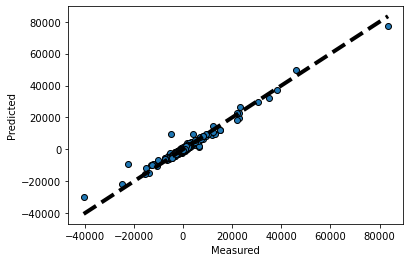

In [64]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = est.fit()
print(results.summary())

In [210]:
county_order

array([ 1103, 39071, 29103, ..., 19183, 23017, 46029])

### Emily's Code

Basically just replaced sklearn LinearRegression with statsmodel version of OLS 

In [205]:
year_start_test = 2010
test_years = np.arange(year_start_test, 2020)

# split training dataset
X_train,y_train = split_train_data(data_combine, year_start_test)

errors = {}
predictions = []

for i in range(len(test_years)):
    X_test, y_test, county_order = split_test_data(data_combine, test_years[i])
    
    # Create linear regression using statsmodel and train model using training sets
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    
    print(model.summary())
    X_test=sm.add_constant(X_test)
    # Make predictions using the testing set
    y_pred = model.predict(X_test)
    
    # Output purposes
    #year_pred_gt = {}
    #for j in range(len(county_order)):
        #year_pred_gt[str(county_order[j]).zfill(5)] = {'gt': y_test.values[j], 'pred': y_pred[j], 
                                                    #'diff': y_test.values[j] - y_pred[j]}
    #predictions.append(year_pred_gt)
    
    # calculate error
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)
    
    # put testing data into training set
    X_train = pd.concat([X_train, X_test])
    y_train = pd.concat([y_train, y_test])
    
    errors[test_years[i]] = {'rmse': rmse, 'r2': r2}


                            OLS Regression Results                            
Dep. Variable:                num_ind   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 6.208e+04
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        12:20:28   Log-Likelihood:            -3.9248e+05
No. Observations:               45887   AIC:                         7.850e+05
Df Residuals:                   45882   BIC:                         7.850e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [206]:
errors

{2010: {'rmse': 790.3765180420099, 'r2': 0.7965496531264604},
 2011: {'rmse': 835.0825065364903, 'r2': 0.6457725726367427},
 2012: {'rmse': 1203.6047194188016, 'r2': 0.48712259562876326},
 2013: {'rmse': 979.6834914476267, 'r2': 0.7866217148333426},
 2014: {'rmse': 1592.8896054217075, 'r2': 0.6635291450656267},
 2015: {'rmse': 2183.729589987579, 'r2': -1.1066904587204767},
 2016: {'rmse': 1572.2180295120284, 'r2': 0.6551535146092902},
 2017: {'rmse': 2277.7764987712508, 'r2': 0.7028900251076033},
 2018: {'rmse': 894.5756156629002, 'r2': 0.909174067916688},
 2019: {'rmse': 544.1731373680581, 'r2': 0.9622712281296274}}

### Emily's Code

Using the split_train and split_test methods, applying a XGBOOST model and evaluating based on RMSE, 
not currently performing better than LinearRegression

In [ ]:
def split_train_data(data, year_start_test):
    '''
    Takes only data before the year_start_test
    '''
    data_before_year = data[data['year'] < year_start_test].sample(frac = 1) # shuffle
    X = data_before_year.iloc[:,3:]
    y = data_before_year['num_ind']
    return X,y

def split_test_data(data, test_year):
    '''
    Takes only data of the test_year
    '''
    data_of_year = data[data['year'] == test_year].sample(frac = 1) #shuffle
    X = data_of_year.iloc[:,3:]
    y = data_of_year['num_ind']
        
    county_order = data_of_year['FIPS'].values
    return X,y, county_order

In [90]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(X_train, y_train, X_test):
    # transform list into array
    #train = np.array(train)
    # split into input and output columns
    #trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    # make a one-step prediction
    yhat = model.predict(np.array([X_test]))
    return yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
#         print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        
    # estimate prediction error
    error_mae = mean_absolute_error(test[:, -1], predictions)
    error_rmse = mean_squared_error(test[:, -1], predictions, squared = False)
    return error_mae, error_rmse, test[:, -1], predictions

#### XGBOOST Code: attemting to work out 1 iteration using code below, refer to xgboost_forecast and walk_forward_validation later lol

In [207]:
X_train,y_train = split_train_data(data_combine, 2010)
X_test, y_test, county_order = split_test_data(data_combine, 2011)
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)
X_test = X_test[X_train.columns]
yhat = model.predict(X_test)
#predictions.append(yhat)

In [208]:
error_mae = mean_absolute_error(y_test, yhat)
error_rmse = mean_squared_error(y_test, yhat, squared = False)

In [209]:
print(error_mae)
print(error_rmse)

280.1853892803577
1329.174302354061


In [199]:
p = [round(value) for value in yhat]
accuracy = accuracy_score(y_test, p)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 0.56%


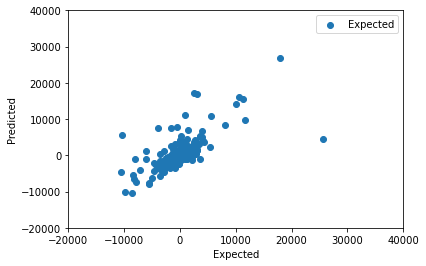

In [195]:
plt.scatter(y_test,yhat, label='Expected')
plt.xlim(-20000, 40000)
plt.ylim(-20000, 40000)
plt.xlabel("Expected")
plt.ylabel("Predicted")
#plt.scatter(yhat, label='Predicted')
plt.legend()
plt.show()

In [151]:
#COME BACK to this: need to figure out predictions for 1 year, then can work on sliding window
year_start_test = 2010

train_years= np.arange(1995,year_start_test)
test_years = np.arange(year_start_test, 2020)
# split training dataset, all years prior to year_start_test available

errors = {}
predictions = []
for i in range(len(test_years)):
    year_start_train=year_start_train + i
    year_start_test=year_start_test + i
    
    X_train,y_train = split_train_data(data_combine, train_years[i], test_years[i])
    X_test, y_test, county_order = split_test_data(data_combine, test_years[i])
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(X_train, y_train)
    X_test = X_test[X_train.columns]
    yhat = model.predict(X_test)
    predictions.append(yhat)
    len(yhat)

## Plot Difference In Predictions

In [55]:
# Import shapefile
shapefile_fn = "Cleaned_Data/boundary_shapefiles/cb_2015_us_county_500k.shp"
shapefile_key = "GEOID"

county_map = gpd.read_file(shapefile_fn)

In [56]:
# calculate difference between prediction and ground truth
diffs = {}
for i in range(len(test_years)):
    df = pd.DataFrame(predictions[i]).T
    diffs[test_years[i]] = df['diff']
diffs = pd.DataFrame(diffs)

# take mean of all years
diff_avg = diffs.mean(axis = 1).to_dict()

In [25]:
diff_vals = np.array(list(diff_avg.values()))

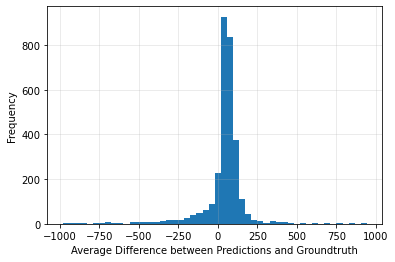

In [26]:
plt.hist(diff_vals[(diff_vals > -1000) & (diff_vals < 1000)], bins = 50)
# plt.vlines(0, 1000, np.mean(diff_vals), linestyle = '--')
plt.ylabel('Frequency')
plt.xlabel('Average Difference between Predictions and Groundtruth')
plt.grid(alpha = 0.3)
plt.show()

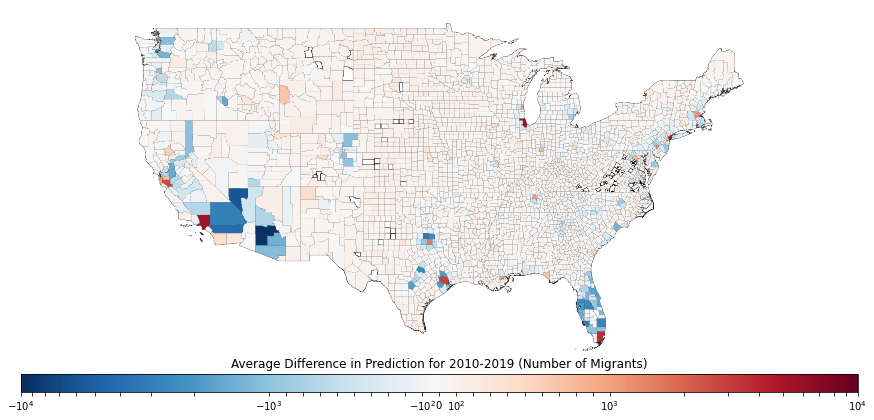

In [27]:
# plot to map
county_map['pred_mig'] = county_map['GEOID'].map(diff_avg)

fig, ax = plt.subplots(1,1, figsize = (15,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

plt.title('Average Difference in Prediction for 2010-2019 (Number of Migrants)')
county_map.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
county_map.plot(column= 'pred_mig', ax = ax, cmap = "RdBu_r", legend = True,
#                 norm = colors.TwoSlopeNorm(vcenter = 0),
                norm = colors.SymLogNorm(linthresh = 1e3,vmin=-1e4, vmax=1e4),
#                    norm = colors.LogNorm(vmin=1e1, vmax=1e6),
               legend_kwds={'orientation': "horizontal"}, cax = cax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.show()

In [28]:
print('Model underpredicts county {} the most'.format(min(diff_avg, key = diff_avg.get)))
print('Model overpredicts county {} the most'.format(max(diff_avg, key = diff_avg.get)))

Model underpredicts county 04013 the most
Model overpredicts county 17031 the most
